# Optimization of E. coli growth parameters for NUFEB
This notebook utilizes hyperparameter optimization to fit simulated E. coli growth curves to experimental data. Under the hood, we use scikit-optimize to perform a Bayesian optimization.

In [1]:
#Imports
import os
from random import uniform
from pathlib import Path
from nufeb_tools import utils,plot,spatial
import pandas as pd
from string import Template
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import joblib
import subprocess
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize,load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective,plot_gaussian_process
from scipy.optimize import curve_fit
from scipy import interpolate
from skopt import Optimizer
from skopt.space import Real
from skopt.benchmarks import branin
import shutil


In [2]:
from tqdm.notebook import tqdm
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        self._bar.update()

    def __getstate__(self):
        state = self.__dict__.copy()
        del state['_bar']
        return state

In [3]:
expPath = r'/home/jonathan/nufeb-cyano-e-coli/experimental-data/ecw-growth-R2.xlsx'
growthData = pd.read_excel(expPath,sheet_name='Growth')
expSucrose =pd.read_excel(expPath,sheet_name='Sucrose')
expSucrose

,Time,Sucrose,Initial Sucrose,Replicate
0,0,1.892480,2,1
1,4,1.832000,2,1
2,6,1.586310,2,1
3,8,0.871310,2,1
4,10,0.276060,2,1
...,...,...,...,...
123,8,15.241357,20,4
124,10,11.745500,20,4
125,13,9.353344,20,4
126,19,9.554274,20,4


In [4]:
growthData = growthData.loc[growthData['Initial Sucrose'] !=20]
growthData=growthData.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','OD600']]
growthData.head()

,Time,Initial Sucrose,OD600
0,0,2,0.010000
1,0,5,0.010000
2,0,10,0.010000
3,1,2,0.010000
4,1,5,0.016333


In [5]:
expSucrose = expSucrose.loc[expSucrose['Initial Sucrose'] !=20]
expSucrose = expSucrose.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','Sucrose']]
expSucrose.head()

,Time,Initial Sucrose,Sucrose
0,0,2,1.855295
1,0,5,4.685920
2,0,10,9.489184
3,4,2,1.808598
4,4,5,4.631757


In [6]:
growthData10 = growthData.loc[(growthData['Initial Sucrose']==10) & (growthData.Time < 15)]
expSucrose10 = expSucrose.loc[(expSucrose['Initial Sucrose']==10) & (expSucrose.Time < 15)]

In [7]:
expSucrose10

,Time,Initial Sucrose,Sucrose
2,0,10,9.489184
5,4,10,9.225052
8,6,10,8.345636
11,8,10,6.275219
14,10,10,3.035694
17,13,10,0.881312


# Optimization function
## Parameters to optimize:
### $\mu_{max}$ (Monod-based growth rate, $s^{-1}$)
### $\rho$ (Cell density, $\frac{kg}{m^3}$)
### $k_{sucrose}$ (Sucrose uptake half-maximum, $\frac{kg}{m^3}$)
### m (Cellular maintenance cost, $s^{-1}$)

In [8]:
#Volume = 1e-4*1e-4*1e-4 #m^3
#mlm3 = 1e6 #mL/m^3
#Biomass2OD = Volume*.44


In [9]:
def mu_func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))

In [10]:
def run_sim(folder):
    os.chdir(folder)
    in_path = folder / 'Inputscript.lammps'
    try:
        os.system(f'mpirun -np 1 /home/jonathan/NUFEB/lammps/src/lmp_png -in {in_path} > nufeb.log')
        #subprocess.run(['mpirun', '-np', '4','/home/jsakkos/NUFEB/lammps/src/lmp_png','-in', '*.lammps > nufeb.log'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        #os.chdir(r'/home/jsakkos/NUFEB')
        return folder
    except:
        print('Something went wrong')
def collect_data(folder):
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]
    return temp
def run_collect(folder):
    os.chdir(folder)
    in_path = folder / 'Inputscript.lammps'
    os.system(f'mpirun -np 1 /home/jonathan/NUFEB/lammps/src/lmp_png -in {in_path} > nufeb.log')
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]
    return temp
def func(x,growth=growthData10,sucrose=expSucrose10):
   
    mu = x[0]
    #rho = x[1]
    #ksuc = x[2]
    #yield_ = x[3]
    maint = 0#x[3]
    print(f'mu: {mu:.3e}')#,rho: {rho:.3e},ksuc: {ksuc:.3e}
    SucroseMW = 342.3
    os.chdir('/home/jonathan/NUFEB')
    SucroseMW = 342.3
    rng = str(np.random.randint(0,1e6,1)[0])
    os.mkdir(rng)
    os.chdir(rng)
    dir_path = Path(os.getcwd()).resolve()
    text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 100 --t 4700 --suc 29.2 --muecw {mu} --maintecw {maint} --yieldecw .49 --niter 1000000 --mass 7e-12 --biodt 1 --suc_halt 1 --division off'
    os.system(text)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
    #tmp=Parallel(n_jobs=-1)(delayed(run_collect)(folder) for folder in folders)
    data = run_collect(folders[0])
    #data=pd.concat((futures[i].result() for i in range(3)),ignore_index=True) 
    df = data.groupby(['Hours','S0']).mean().reset_index()
    df.loc[df.S0==10]
    g=interpolate.interp1d(df.Hours,df.OD600,fill_value='extrapolate')
    rmse = mean_squared_error(growth.OD600, g(growth.Time), sample_weight=growth.OD600,squared = False)
    r2g = r2_score(growth.OD600, g(growth.Time))
    suc=interpolate.interp1d(df.Hours,df.Sucrose,fill_value='extrapolate')
    rmse += mean_squared_error(sucrose.Sucrose, suc(sucrose.Time), sample_weight=sucrose.Sucrose,squared = False)
    r2s = r2_score(sucrose.Sucrose, suc(sucrose.Time))
    f, axes = plt.subplots(ncols=2)
    sns.scatterplot(x='Time',y='OD600',data=growth,ax=axes[0],label='Experimental')
    sns.scatterplot(x='Time',y='Sucrose',data=sucrose,ax=axes[1],label='Experimental')
    axes[0].plot(df.Hours,df.OD600,color='red',label='Simulated')
    axes[1].plot(df.Hours,df.Sucrose,color='red',label='Simulated')
    #sns.lineplot(x='Hours',y='OD600',data=df,ax=axes[0],palette='Reds',label='Simulated')
    #sns.lineplot(x='Hours',y='Sucrose',data=df,ax=axes[1],palette='Reds',label='Simulated')
    #plot
    sns.despine()
    plt.show()
    print(f'R2 = {r2g:.3f} (growth),{r2s:.3f} (sucrose)')
    os.chdir('/home/jonathan/NUFEB')
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))
    return rmse

In [100]:
# os.chdir('/home/jonathan/NUFEB')
# os.system('nufeb-clean')
# SucroseMW = 342.3
# for s in growthData['Initial Sucrose'].unique():
#     suc = s*1e3/SucroseMW
#     text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc:.2f} --muecw 4.5e-4  --rhoecw 280 --ksuc .1 --maintecw 0 --niter 1000000 --mass 1e-11 --yieldecw 0.8'
#     os.system(text)
# BASE_DIR = Path(f'runs/')
# folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
# tmp=Parallel(n_jobs=12)(delayed(run_collect)(folder) for folder in folders)

# data = pd.concat(tmp,ignore_index=True)
# df = data.groupby(['Hours','S0']).mean().reset_index()
# f, axes = plt.subplots(ncols=2)
# sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
# sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
# sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
# sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])

In [102]:
# def func(x,growth=growthData,sucrose=expSucrose):

#     mu = x[0]
#     rho = x[1]
#     ksuc = x[2]
#     maint = 0#x[3]
#     SucroseMW = 342.3

#     #Clean old simulations
#     os.chdir('/home/jsakkos/NUFEB')
#     rng = str(np.random.randint(0,1e6,1)[0])
#     os.mkdir(rng)
#     os.chdir(rng)
#     dir_path = Path(os.getcwd()).resolve()
#     #os.system('nufeb-clean')

    
#     print(f'mu: {mu:.3e},rho: {rho:.3e},ksuc: {ksuc:.3e}, m {maint:.3e}')
#     # generate simulations for several initial sucrose concentrations
#     for s in growthData['Initial Sucrose'].unique():
#         suc = s*1e3/SucroseMW
#         text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc:.2f} --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint} --niter 1 --mass 7e-12'
#         os.system(text)
#     #Run new simulations
#     #os.system('/home/jsakkos/par.sh')
#     BASE_DIR = Path(f'runs/')
#     folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
#     try:
#         _=Parallel(n_jobs=3)(delayed(run_sim)(folder) for folder in folders)
#     except:
#         print('error')
#     tmp=Parallel(n_jobs=3)(delayed(collect_data)(folder) for folder in folders)
#     data = pd.concat(tmp,ignore_index=True)
#     df = data.groupby(['Hours','S0']).mean().reset_index()
#     f, axes = plt.subplots(ncols=2)
#     sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
#     sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
#     sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
#     sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])
#     #plot
#     sns.despine()
#     plt.show()
#     rmse = 0
#     r2g=0
#     r2s=0
#     for s in growthData['Initial Sucrose'].unique():
#         temp = growthData.loc[growthData['Initial Sucrose']==s]
#         g=interpolate.interp1d(df.Hours,df.OD600)
#         rmse += mean_squared_error(temp.OD600, g(temp.Time), sample_weight=temp.OD600,squared = False)
#         r2g += r2_score(temp.OD600, g(temp.Time))
#         temp2 = expSucrose.loc[expSucrose['Initial Sucrose']==s]
#         suc=interpolate.interp1d(df.Hours,df.Sucrose)
#         #rmse += mean_squared_error(temp2.Sucrose, suc(temp2.Time), sample_weight=temp2.Sucrose,squared = False)
#         r2s += r2_score(temp2.Sucrose, suc(temp2.Time))
#     r2g=r2g/len(growthData['Initial Sucrose'].unique())
#     r2s=r2s/len(growthData['Initial Sucrose'].unique())

#     print(f'R2 = {r2g:.3f} (growth),{r2s:.3f} (sucrose)')
#     os.chdir('/home/jsakkos/NUFEB')
#     try:
#         shutil.rmtree(dir_path)
#     except OSError as e:
#         print("Error: %s : %s" % (dir_path, e.strerror))
#     return rmse


Gaussian Process:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
mu: 3.143e-04


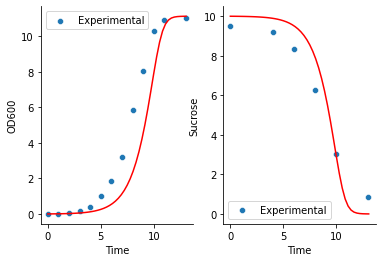

R2 = 0.850 (growth),0.911 (sucrose)
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 174.4584
Function value obtained: 3.1468
Current minimum: 3.1468
Iteration No: 2 started. Evaluating function at random point.
mu: 5.662e-04


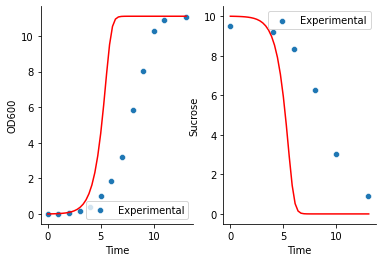

R2 = 0.256 (growth),-0.676 (sucrose)
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 136.9076
Function value obtained: 7.8004
Current minimum: 3.1468
Iteration No: 3 started. Evaluating function at random point.
mu: 1.965e-04


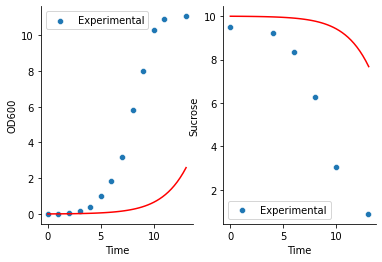

R2 = -0.484 (growth),-0.640 (sucrose)
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 91.2960
Function value obtained: 10.8370
Current minimum: 3.1468
Iteration No: 4 started. Evaluating function at random point.
mu: 3.493e-04


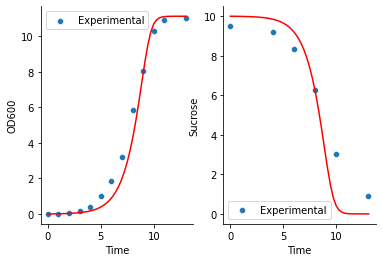

R2 = 0.978 (growth),0.855 (sucrose)
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 171.3383
Function value obtained: 1.6245
Current minimum: 1.6245
Iteration No: 5 started. Evaluating function at random point.
mu: 5.582e-04


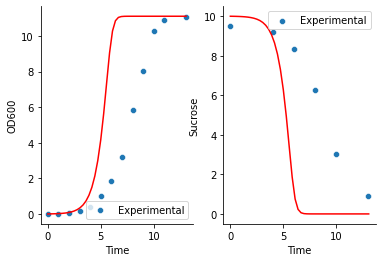

R2 = 0.290 (growth),-0.604 (sucrose)
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 136.8105
Function value obtained: 7.6473
Current minimum: 1.6245
Iteration No: 6 started. Evaluating function at random point.
mu: 5.073e-04


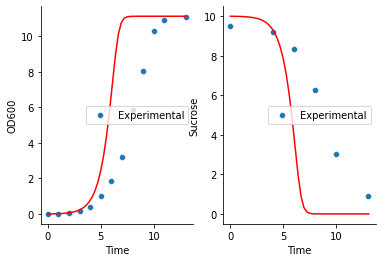

R2 = 0.502 (growth),-0.097 (sucrose)
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 144.5274
Function value obtained: 6.4485
Current minimum: 1.6245
Iteration No: 7 started. Evaluating function at random point.
mu: 1.203e-04


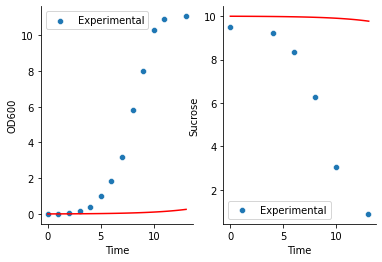

R2 = -0.816 (growth),-1.279 (sucrose)
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 23.0552
Function value obtained: 12.0543
Current minimum: 1.6245
Iteration No: 8 started. Evaluating function at random point.
mu: 1.742e-04


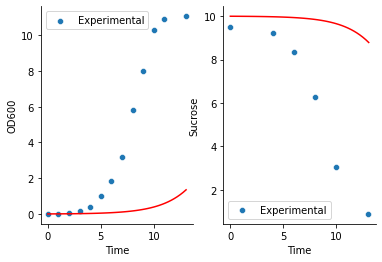

R2 = -0.647 (growth),-0.955 (sucrose)
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 67.2598
Function value obtained: 11.4498
Current minimum: 1.6245
Iteration No: 9 started. Evaluating function at random point.
mu: 9.277e-04


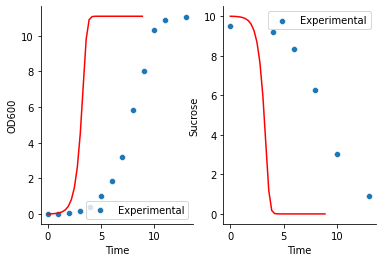

R2 = -0.689 (growth),-2.218 (sucrose)
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 104.8649
Function value obtained: 10.3775
Current minimum: 1.6245
Iteration No: 10 started. Evaluating function at random point.
mu: 9.689e-04


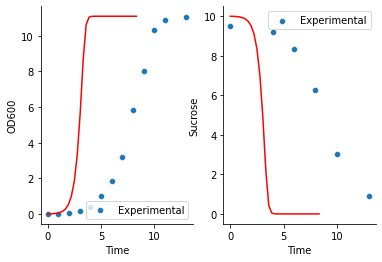

R2 = -0.738 (growth),-2.242 (sucrose)
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 104.1071
Function value obtained: 10.4110
Current minimum: 1.6245
Iteration No: 11 started. Searching for the next optimal point.
mu: 3.879e-04


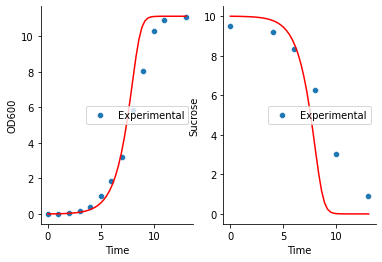

R2 = 0.957 (growth),0.694 (sucrose)
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 163.9960
Function value obtained: 2.7604
Current minimum: 1.6245
Iteration No: 12 started. Searching for the next optimal point.
mu: 3.522e-04


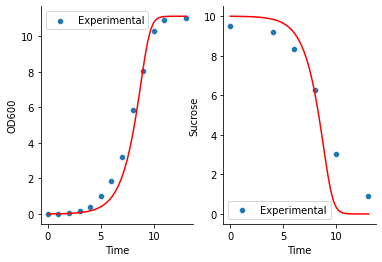

R2 = 0.981 (growth),0.848 (sucrose)
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 170.8101
Function value obtained: 1.5907
Current minimum: 1.5907
Iteration No: 13 started. Searching for the next optimal point.
mu: 3.550e-04


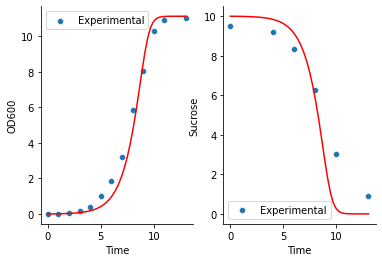

R2 = 0.983 (growth),0.841 (sucrose)
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 169.1596
Function value obtained: 1.5815
Current minimum: 1.5815
Iteration No: 14 started. Searching for the next optimal point.
mu: 3.558e-04


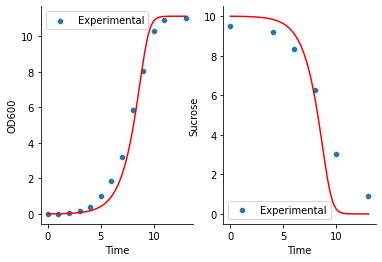

R2 = 0.984 (growth),0.839 (sucrose)
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 169.7471
Function value obtained: 1.5831
Current minimum: 1.5815
Iteration No: 15 started. Searching for the next optimal point.
mu: 3.558e-04


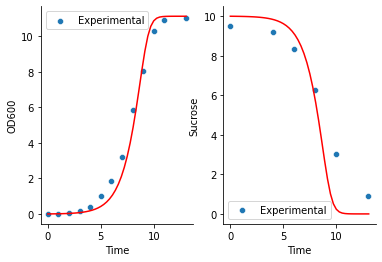

R2 = 0.984 (growth),0.839 (sucrose)
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 168.9258
Function value obtained: 1.5830
Current minimum: 1.5815
Iteration No: 16 started. Searching for the next optimal point.
mu: 3.557e-04


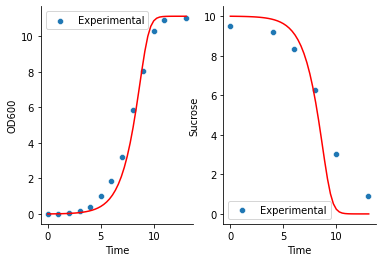

R2 = 0.984 (growth),0.839 (sucrose)
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 168.3771
Function value obtained: 1.5830
Current minimum: 1.5815
Iteration No: 17 started. Searching for the next optimal point.
mu: 3.557e-04


/home/jonathan/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


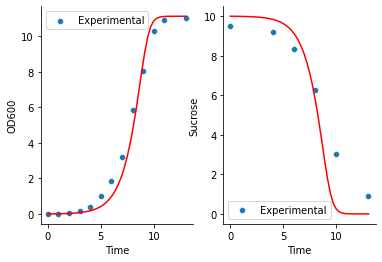

R2 = 0.984 (growth),0.840 (sucrose)
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 170.0629
Function value obtained: 1.5832
Current minimum: 1.5815
Iteration No: 18 started. Searching for the next optimal point.
mu: 3.556e-04


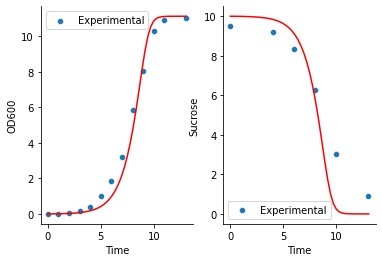

R2 = 0.984 (growth),0.840 (sucrose)
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 170.0687
Function value obtained: 1.5825
Current minimum: 1.5815
Iteration No: 19 started. Searching for the next optimal point.
mu: 3.554e-04


Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7fc58b1f13a0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/_weakrefset.py", line 38, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


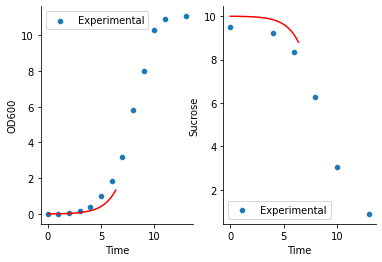

R2 = 0.616 (growth),0.780 (sucrose)
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 68.4136
Function value obtained: 5.2066
Current minimum: 1.5815
Iteration No: 20 started. Searching for the next optimal point.
mu: 3.944e-04



KeyboardInterrupt



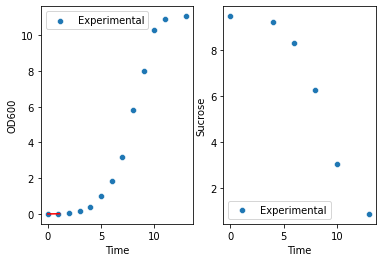

In [103]:
# optimizer = Optimizer(
#     dimensions=[Real(float('5e-5'), float('8e-4')), 
#                 Real(180, 307),
#                 Real(float('1e-1'),float('1e1')),
#                 Real(0.43,0.49)],
#     random_state=1,
#     base_estimator='gp',
#     verbose=True,
# )
bounds=[Real(float('5e-5'), float('1e-3'))]

# for i in tqdm(range(50)):
#     x = optimizer.ask()# x is a list of n_points points
#     y = func(x)  # evaluate points in parallel
#     optimizer.tell(x, y)
# print(min(optimizer.yi)) # print the best objective found
checkpoint_saver = CheckpointSaver(r"/home/jonathan/nufeb-cyano-e-coli/checkpoints/ecw.pkl", compress=9)
n_calls = 40
gp_res = gp_minimize(func, bounds, n_calls=n_calls,n_initial_points=10,
                     random_state=5348,verbose=True,
                     callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process"),checkpoint_saver],
                     n_jobs=-1)

In [104]:
gp_res=load("/home/jonathan/nufeb-cyano-e-coli/checkpoints/ecw.pkl")

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

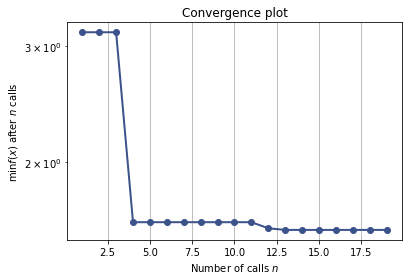

In [105]:
plot_convergence(gp_res,yscale='log')

<AxesSubplot:xlabel='$\\mu$', ylabel='Partial dependence'>

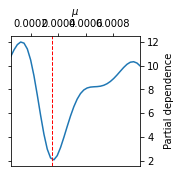

In [106]:
plot_objective(gp_res,dimensions=[r'$\mu$'],cmap='inferno')

In [107]:
gp_res.x

[0.0003550039746250766]

mu: 3.550e-04


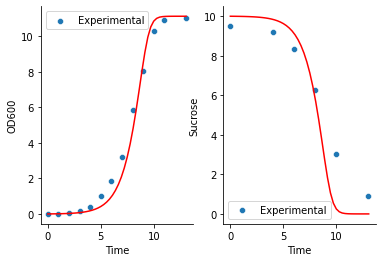

R2 = 0.983 (growth),0.841 (sucrose)


1.580890904472895

In [108]:
func([gp_res.x[0],230,3.6],growth=growthData10,sucrose=expSucrose10)

In [122]:
os.chdir('/home/jonathan/NUFEB')
os.system('nufeb-clean')
text = f'nufeb-seed --n 1 --od 0.3,0.3 --d 1e-4,1e-4,1e-5  --muecw 3.55e-4 --yieldecw .49 --iptg 1 --niter 1000000'
os.system(text)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
#tmp=Parallel(n_jobs=-1)(delayed(run_collect)(folder) for folder in folders)
#data = run_collect(folders[0])

In [124]:
os.chdir('/home/jonathan')
x = utils.get_data(directory='runs/Run_9_40_1.00e+00_1_2022-04-27_206199')
#metrics = spatial.fitness_metrics(x)

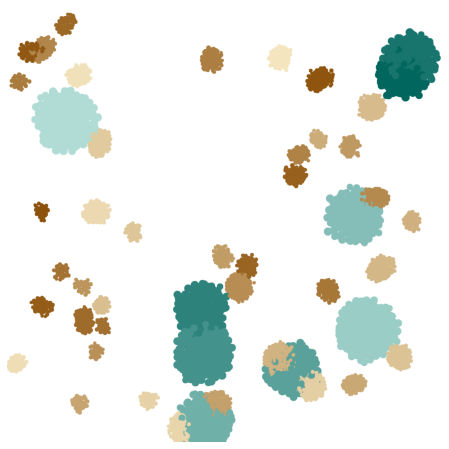

In [127]:
f, ax = plt.subplots(figsize=(8,8))
im = plot.colony(x,35000,by='Species',ax=ax)
#colony(x,25900,ax=ax)
ax.set_axis_off()
#f.savefig(r'../figures/colonies.pdf',dpi=300,bbox_inches='tight')
plt.show()

<AxesSubplot:xlabel='Time', ylabel='Sucrose'>

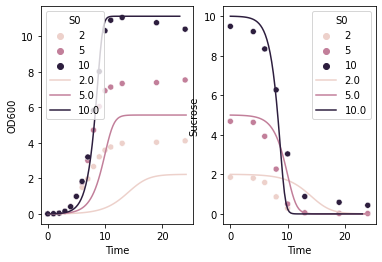

In [11]:
os.chdir('/home/jonathan/ecw')
os.system('nufeb-clean')
SucroseMW = 342.3
for s in growthData['Initial Sucrose'].unique():
    suc = s*1e3/SucroseMW
    text = f'nufeb-seed --n 3 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 100 --t 8700 --suc {suc:.2f} --maintecw 0 --biodt 1 --suc_halt 1 --division off'
    os.system(text)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
tmp=Parallel(n_jobs=-1)(delayed(run_collect)(folder) for folder in folders)
data = pd.concat(tmp,ignore_index=True)
df = data.groupby(['Hours','S0']).mean().reset_index()
f, axes = plt.subplots(ncols=2)
sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])

<AxesSubplot:xlabel='Hours', ylabel='OD600'>

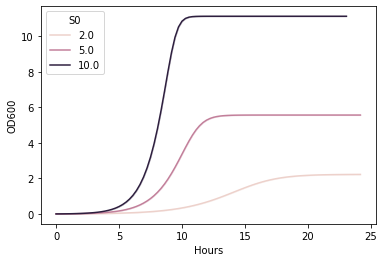

In [14]:
sns.lineplot(x='Hours',y='OD600',hue='S0',ci='sd',data=data)

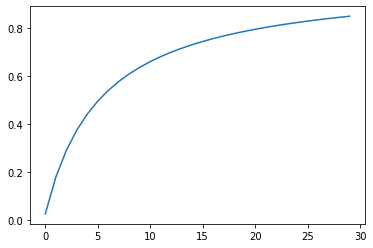

In [37]:
def monod_func(x):
    return x/(x+3.6)
xrange = np.linspace(.1,20,30)
plt.plot(monod_func(xrange))

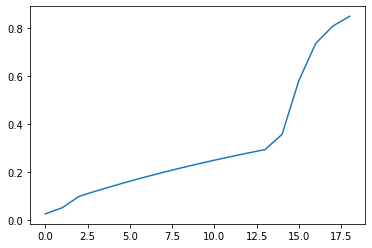

In [30]:
s0=np.array([.1,.2,.4,.5,.6,.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5,2,5,10,15,20])
plt.plot(monod_func(s0))

In [39]:
os.chdir('/home/jonathan/ecw')
os.system('nufeb-clean')
SucroseMW = 342.3
suc = 10*1e3/SucroseMW
text = f'nufeb-seed --n 3 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 100 --t 8700 --suc {suc:.2f} --maintecw 0 --biodt 1 --suc_halt 1 --division off'
os.system(text)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
tmp=Parallel(n_jobs=-1)(delayed(run_collect)(folder) for folder in folders)


<AxesSubplot:xlabel='Time', ylabel='Sucrose'>

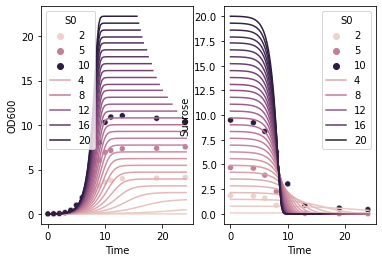

In [38]:
os.chdir('/home/jonathan/ecw')
os.system('nufeb-clean')
SucroseMW = 342.3
for s in np.linspace(.1,20,30):
    suc = s*1e3/SucroseMW
    text = f'nufeb-seed --n 3 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 100 --t 8700 --suc {suc:.2f} --maintecw 0 --biodt 1 --suc_halt 1 --division off'
    os.system(text)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
tmp=Parallel(n_jobs=-1)(delayed(run_collect)(folder) for folder in folders)
data = pd.concat(tmp,ignore_index=True)
df = data.groupby(['Hours','S0']).mean().reset_index()
f, axes = plt.subplots(ncols=2)
sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])